# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
seed=4

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher', seed=seed, worker_id=1)

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+00
 -8.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -6.97666168e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


In [5]:
from ddpg_agent import Agent
from collections import deque
import torch

agent = Agent(state_size, action_size, seed)
agent.actor_local.load_state_dict(torch.load('actor.pth'))
agent.critic_local.load_state_dict(torch.load('critic.pth'))



<All keys matched successfully>

# Training

When finished, you can close the environment.

In [6]:

print_every = 10
save_every = 100


def train(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.0001):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    total_scores = []      # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations          # get the current state
        agent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(eps, state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            scores += reward

            agent.step(t, state, action, reward, next_state, done)
            state = next_state

            if np.any(done):
                break
        scores_window.append(scores)
        total_scores.append(scores)
        total_average_score = np.mean(scores_window)
        eps = max(eps_end, eps-eps_decay) # decrease epsilon
        if i_episode % print_every == 0:
            print('\rEpisode {}\tTotal Average Score: {:.2f}'.
                  format(i_episode, total_average_score))

        if i_episode % save_every == 0:
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
        if np.mean(scores_window) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                  .format(i_episode-100, total_average_score))
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
            break

    return total_scores

scores = train()

Episode 10	Total Average Score: 2.92
Episode 20	Total Average Score: 2.21
Episode 30	Total Average Score: 1.81
Episode 40	Total Average Score: 1.70
Episode 50	Total Average Score: 1.79
Episode 60	Total Average Score: 2.06
Episode 70	Total Average Score: 2.32
Episode 80	Total Average Score: 2.56
Episode 90	Total Average Score: 2.91
Episode 100	Total Average Score: 3.17
Episode 110	Total Average Score: 3.57
Episode 120	Total Average Score: 3.83
Episode 130	Total Average Score: 4.23
Episode 140	Total Average Score: 4.62
Episode 150	Total Average Score: 4.80
Episode 160	Total Average Score: 5.00
Episode 170	Total Average Score: 5.24
Episode 180	Total Average Score: 5.48
Episode 190	Total Average Score: 5.66
Episode 200	Total Average Score: 5.75
Episode 210	Total Average Score: 5.82
Episode 220	Total Average Score: 6.04
Episode 230	Total Average Score: 6.22
Episode 240	Total Average Score: 6.52
Episode 250	Total Average Score: 6.73
Episode 260	Total Average Score: 6.99
Episode 270	Total Ave

Episode 2110	Total Average Score: 29.45
Episode 2120	Total Average Score: 29.60
Episode 2130	Total Average Score: 29.68
Episode 2140	Total Average Score: 29.94

Environment solved in 2048 episodes!	Average Score: 30.01


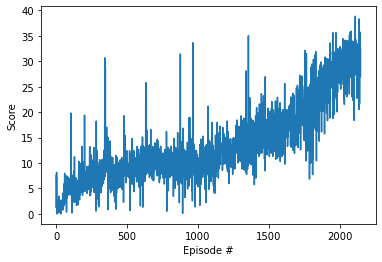

In [9]:
import matplotlib.pyplot as plt
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')

plt.xlabel('Episode #')
plt.show()


In [8]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 